# Introduction to image classification using camera trap images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Set up your environment

```
pip install pandas matplotlib Pillow tqdm scikit-learn torch torchvision
```



## 2. Download the data


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

print(torch.cuda.device(0))

torch.cuda.get_device_name(0)

True
1
0


'Tesla T4'

In [4]:
drive_path = '/content/drive/My Drive/DL_project/'

# Carregar os arquivos CSV
train_features = pd.read_csv(f"{drive_path}train_features.csv", index_col="id")
test_features = pd.read_csv(f"{drive_path}test_features.csv", index_col="id")
train_labels = pd.read_csv(f"{drive_path}train_labels.csv", index_col="id")
import pandas as pd

# Assuming train_features is your DataFrame and 'filepath' is the column with paths
train_features['filepath'] = train_features['filepath'].apply(lambda x: f"{drive_path}/train_features/{x.split('/')[-1]}")

# Save updated CSV
train_features.to_csv(f"{drive_path}train_features.csv")


# Assuming train_features is your DataFrame and 'filepath' is the column with paths
test_features['filepath'] = test_features['filepath'].apply(lambda x: f"{drive_path}/test_features/{x.split('/')[-1]}")

# Save updated CSV
test_features.to_csv(f"{drive_path}test_features.csv")

In [5]:
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [6]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

## 3. Explore the data

Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label. You can try changing the `random_state` variable to display a new set of images.

In [7]:
'''import matplotlib.image as mpimg

random_state = 42

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")'''

'import matplotlib.image as mpimg\n\nrandom_state = 42\n\n# we\'ll create a grid with 8 positions, one for each label (7 species, plus blanks)\nfig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))\n\n# iterate through each species\nfor species, ax in zip(species_labels, axes.flat):\n    # get an image ID for this species\n    img_id = (\n        train_labels[train_labels.loc[:,species] == 1]\n        .sample(1, random_state=random_state)\n        .index[0]\n    )\n    # reads the filepath and returns a numpy array\n    img = mpimg.imread(train_features.loc[img_id].filepath)\n    # plot etc\n    ax.imshow(img)\n    ax.set_title(f"{img_id} | {species}")'

Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

In [8]:
train_labels.sum().sort_values(ascending=False)

,0
monkey_prosimian,2492.0
antelope_duiker,2474.0
civet_genet,2423.0
leopard,2254.0
blank,2213.0
rodent,2013.0
bird,1641.0
hog,978.0


In [9]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

,0
monkey_prosimian,0.151140
antelope_duiker,0.150049
civet_genet,0.146955
leopard,0.136705
blank,0.134219
rodent,0.122089
bird,0.099527
hog,0.059316


## 4. Split into train and evaluation sets
First, we'll need to split the images into train and eval sets. We'll put aside 25% of the data for evaluation and stratify by the target labels to ensure we have similar relative frequencies of each class in the train and eval sets.

For the purposes of this benchmark, we're also going to limit ourselves to a 50% subset of the training data, just so that things run faster. But feel free to adjust `frac` or remove it entirely if you want to run the training on the full set.

In [10]:
from sklearn.model_selection import train_test_split

frac = 0.5

y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

In [11]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((6183, 1), (6183, 8), (2061, 1), (2061, 8))

## 5. Build the Model

### The Dataset

First, we'll create an `ImagesDataset` class that will define how we access our data and any transformations we might want to apply.

This new class will inherit from the PyTorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class, but we'll also need to define our own `__init__`, `__len__` and `__getitem__` **special methods**:
* **`__init__`** will instantiate the dataset object with two dataframes: an `x_train` df containing image IDs and image file paths, and a `y_train` df containing image IDs and labels. This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`.
* **`__getitem__`** will define how we access a sample from the data. This method gets called whenever we use an indexing operation like `dataset[index]`. In this case, whenever accessing a particular image sample (for example, to get the first image we'd do `dataset[0]`) the following will happen:
  * look up the image filepath using the index
  * load the image with [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  * apply some transformations (more on this below)
  * return a dictionary containing the image ID, the image itself as a Tensor, and a label (if it exists)
* **`__len__`** simply returns the size of the dataset, which we do by calling `len` on the input dataframe.

In [12]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values,
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

Notice that we are also defining a set of **transformations**, which are defined in the `__init__` and called in the `__getitem__` special methods. These are applied to each image before returning it. Here's what each of those transformations do and why:

* `transforms.Resize((224, 224))` ResNet50 was trained on images of size 224x224 so we resize to the same dimensions here. See [pytorch docs](https://pytorch.org/vision/stable/models.html) and the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).
* `transforms.ToTensor()` converts the image to a tensor. Since we are passing in a PIL Image at this point, PyTorch can recognize it as an RGB image and will automatically convert the input values which are in the range [0, 255] to a range of [0, 1]. See more from the [PyTorch docs](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html).
* `transforms.Normalize(...)` normalizes the image tensors using the mean and standard deviation of ImageNet images. Because this transformation was applied to images when training the ResNet model, we want to do the same here with our images. See more from the [PyTorch docs on pretrained models](https://pytorch.org/vision/stable/models.html).

### The DataLoader


In [13]:
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 6. Training
Now it's time to start building our model and then training it.

We'll use a pretrained ResNet50 model as our backbone. ResNets are one of the more popular networks for image classification tasks. The pretrained model outputs a 2048-dimension embedding, which we will then connect to two more dense layers, with a ReLU and Dropout step in between.

These final layers, defined in `model.fc`, are the new "head" of our model, and allow us to transform the image embeddings produced by the pretrained "backbone" into the 8-dimensional output required to learn the species classification task we're tackling here. Prior to redefining it below, `model.fc` would be the final, dense layer connecting the 2048-dimension embedding to a 1000-dimension output (corresponding to the 1000 ImageNet classes that the pretrained model was trained on). We will instead prepare the model for the current task by redefining `model.fc` to produce an 8-dimensional output corresponding to our 8 species classes (including blanks).

We'll also add a couple more layers in between. The `ReLU` layer introduces non-linearity into the model head, in effect activating important features and suppressing noise. And the `Dropout` layer is a commonly used regularization component that randomly drops some nodes from the previous layer's outputs (10% of nodes in this case) during each training step, mitigating our risk of overfitting.

In [14]:
from torch import nn
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

model = models.resnet50(pretrained = True)
model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Moving model to cuda

In [15]:
# Cria o modelo e move para a GPU (se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = model.to(device)

Device: cuda


### Define our loss function
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly.

In [16]:
import torch.nn.functional as F


In [17]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing

    def forward(self, pred, target):
        pred = F.log_softmax(pred, dim=1)  # Log-softmax diretamente nas previsões
        with torch.no_grad():
            true_dist = torch.full_like(pred, self.smoothing / (self.num_classes - 1))  # Criação vetorizada
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * pred, dim=1))

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, pred, target):
        ce_loss = F.cross_entropy(pred, target, reduction='none')  # CE Loss por batch
        pt = torch.exp(-ce_loss)  # Probabilidade do rótulo correto
        loss = self.alpha * (1 - pt).pow(self.gamma) * ce_loss  # Evita uso excessivo de memória
        return loss.mean()

# KL Divergence Loss
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super(KLDivergenceLoss, self).__init__()

    def forward(self, pred, target):
        pred = F.log_softmax(pred, dim=1)  # Log-probabilidades
        target = F.one_hot(target, num_classes=pred.size(1)).float().to(pred.device)  # One-hot no mesmo dispositivo
        return F.kl_div(pred, target, reduction='batchmean')


In [18]:
num_classes = len(train_labels.columns)

loss_functions = {
    "Label Smoothing": LabelSmoothingLoss(num_classes=num_classes),
    "CrossEntropy": nn.CrossEntropyLoss(),
    "FocalLoss": FocalLoss(),
    "KLDivergence": KLDivergenceLoss(),
}



In [19]:
def get_loss_function(loss_name):
    return loss_functions[loss_name]

def set_loss_function(loss_name):
    global loss_function
    loss_function = get_loss_function(loss_name)
    return loss_function # This line was added to return the selected loss function



In [20]:
import torch.optim as optim
loss_name = "CrossEntropy"
criterion = set_loss_function(loss_name)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the model
We're now ready to train our model!

We'll start simple and just run it for one epoch, but feel free to run it for more `num_epochs` if you've got the time. We hope to see a decreasing loss as training progresses, which will provide some evidence that the model is learning. Note that we haven't frozen any weights in the pretrained model, a choice which you may want to revisit and we discuss in a little more detail below.

For each epoch we'll iterate through the batches, and for each batch we'll do the following:
1. Zero out the gradients. PyTorch will sum the gradients from past batches when doing its backward pass, so in order to make sure we are only using the gradients computed for the current batch, we zero out the gradients at the beginning of each batch.
2. Run the forward pass.
3. Compute the loss and track it.
4. Compute our gradients and update our weight parameters.

In [21]:
num_epochs = 1

tracking_loss = {}

# clear out the GPU memory cache
torch.cuda.empty_cache()

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # iterate through the dataloader batches. tqdm keeps track of progress.
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for batch_n, batch in pbar:
        # 0) move the data to the GPU
        batch["image"] = batch["image"].to(device)
        batch["label"] = batch["label"].to(device)

        # 0.2) monitor the GPU memory usage
        # allocated_memory = torch.cuda.memory_allocated(device) / 1024**2  # MB
        # reserved_memory = torch.cuda.memory_reserved(device) / 1024**2  # MB
        # max_memory = torch.cuda.max_memory_allocated(device) / 1024**2  # MB
        # pbar.set_description(f"Alocated: {allocated_memory:.2f}MB - Reserved: {reserved_memory:.2f}MB ({device}) - Max: {max_memory:.2f}MB | ")

        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the foward step on this batch of images
        outputs = model(batch["image"])

        #3) Seletor para ajustar o target conforme a função de perda
        if isinstance(loss_function, nn.CrossEntropyLoss) or isinstance(loss_function, FocalLoss):
            # Para CrossEntropy e FocalLoss, usamos o target como índice de classe
            target = batch["label"]  # One-hot -> índice de classe
        elif isinstance(loss_function, LabelSmoothingLoss):
            # Para LabelSmoothing, o target já é um índice de classe, então usamos direto
            target = torch.argmax(batch["label"], dim=1) # O LabelSmoothing já lida com o formato one-hot internamente
        elif isinstance(loss_function, KLDivergenceLoss):
            # Para KLDivergence, o target deve ser one-hot
            target = torch.argmax(batch["label"], dim=1)  # One-hot -> índice de classe
        else:
            raise ValueError("Função de perda não suportada!")
        # 3) compute the loss
        loss = criterion(outputs, target)
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

        # 5) clear out the GPU memory cache
        torch.cuda.empty_cache()
        pbar.set_postfix(loss=loss.item())




Starting epoch 1


100%|██████████| 194/194 [01:38<00:00,  1.96it/s, loss=2.09]


Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

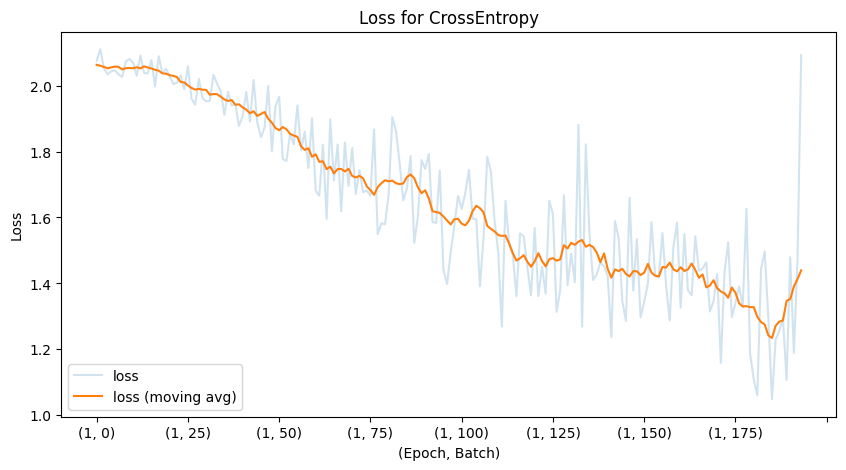

In [22]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.title(f"Loss for {loss_name}")
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

Good news, the loss is going down! This is an encouraging start, especially since we haven't done anything fancy yet.

### Save the model
We have the model loaded in memory already, so we don't really need to save the model, but it's often useful to do this so we can use it again later.

Here's how:

In [23]:
torch.save(model, f"model1_{loss_name}.pth")

## 7. Evaluation
So far, not so bad. We've shown an improvement in the loss on the training set, but that tells us little about how our model will do on new data. Let's reload our saved model and try generating some predictions on the evaluation split we created earlier.

In [24]:
loaded_model = torch.load(f"model1_{loss_name}.pth")

<ipython-input-24-a676eaaa4b74>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f"model1_{loss_name}.pth")


We create the eval dataset and dataloader just like we did earlier with the training dataset and dataloader:

In [25]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

### Make predictions
We'll iterate through the eval dataloader in batches, just like we did for training, but this time we aren't going to need to compute gradients or update weights. For each batch, we'll do the following:
1. Run the forward pass to get the model output or logits
2. Apply a softmax function to convert the logits into probability space with range[0,1]. During training, the softmax operation was handled internally by `nn.CrossEntropyLoss`. We aren't computing the loss now because we are just doing evaluation, but we still want the predictions to be in the range[0,1].
3. Store the results in a dataframe for further analysis

In [26]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):

        # 0) move to cuda
        batch["image"] = batch["image"].to(device)
        batch["label"] = batch["label"].to(device)

        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        preds = preds.cpu()
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 65/65 [00:25<00:00,  2.58it/s]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ008045,0.256810,0.175067,0.141014,0.016257,0.065356,0.084259,0.196735,0.064502
ZJ015719,0.111361,0.039858,0.127406,0.059197,0.167497,0.305394,0.048521,0.140766
ZJ013543,0.312278,0.129441,0.136001,0.038396,0.033106,0.019064,0.235542,0.096173
ZJ001126,0.141850,0.103740,0.103334,0.004194,0.009475,0.017916,0.600941,0.018550
ZJ013411,0.280593,0.167351,0.118900,0.030433,0.046393,0.024362,0.228748,0.103220
...,...,...,...,...,...,...,...,...
ZJ014794,0.142267,0.174787,0.214486,0.007502,0.037294,0.124162,0.265044,0.034457
ZJ009406,0.173780,0.093664,0.059791,0.002720,0.005577,0.008981,0.640958,0.014531
ZJ007374,0.261504,0.203067,0.116001,0.019429,0.038085,0.027982,0.263772,0.070159
ZJ012352,0.210236,0.235247,0.131069,0.015790,0.048082,0.049173,0.255138,0.055265


### Predicted labels distribution
First let's review the species distribution we saw in the training set.

In [27]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


,count
monkey_prosimian,973
antelope_duiker,925
civet_genet,896
blank,860
leopard,841
rodent,732
bird,608
hog,348


Here's the distribution of our predictions on the eval set.

In [28]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


,count
monkey_prosimian,817
civet_genet,330
leopard,329
rodent,239
antelope_duiker,187
blank,91
bird,51
hog,17


The actual evaluation set is more evenly distributed than our predictions, so we already know there is some room for improvement here.

In [29]:
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()

True labels (eval):


,count
monkey_prosimian,325
antelope_duiker,308
civet_genet,298
blank,287
leopard,280
rodent,244
bird,203
hog,116


### Accuracy
Now let's compute how accurate our model is and compare that against some trivial baseline models. First let's get the labels with the highest score for each image.

In [30]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

,0
ZJ008045,antelope_duiker
ZJ015719,leopard
ZJ013543,antelope_duiker
ZJ001126,monkey_prosimian
ZJ013411,antelope_duiker


Random guessing across 8 classes would yield an accuracy of 12.5% (1/8). But we could construct a slightly better trivial model by always guessing the most common class ("monkey_prosimian" images in this case).

If we were to always guess that an image is `monkey_prosimian`, we could achieve accuracy of 15.8%.

In [31]:
eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

0.1576904415332363

Let's see how our model compares. We take the species with the highest score for each image (`eval_predictions`) and compare that to the true labels.

In [32]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.5308102862688016

Our accuracy on the evaluation set is about 50%, which is not a bad start for a very simple first pass and one epoch of training.

Let's look at the predictions from another angle.

We can see from the confusion matrix below that our model does reasonably well on some species, but we have plenty of room for improvement on antelopes, birds, hogs and blanks.

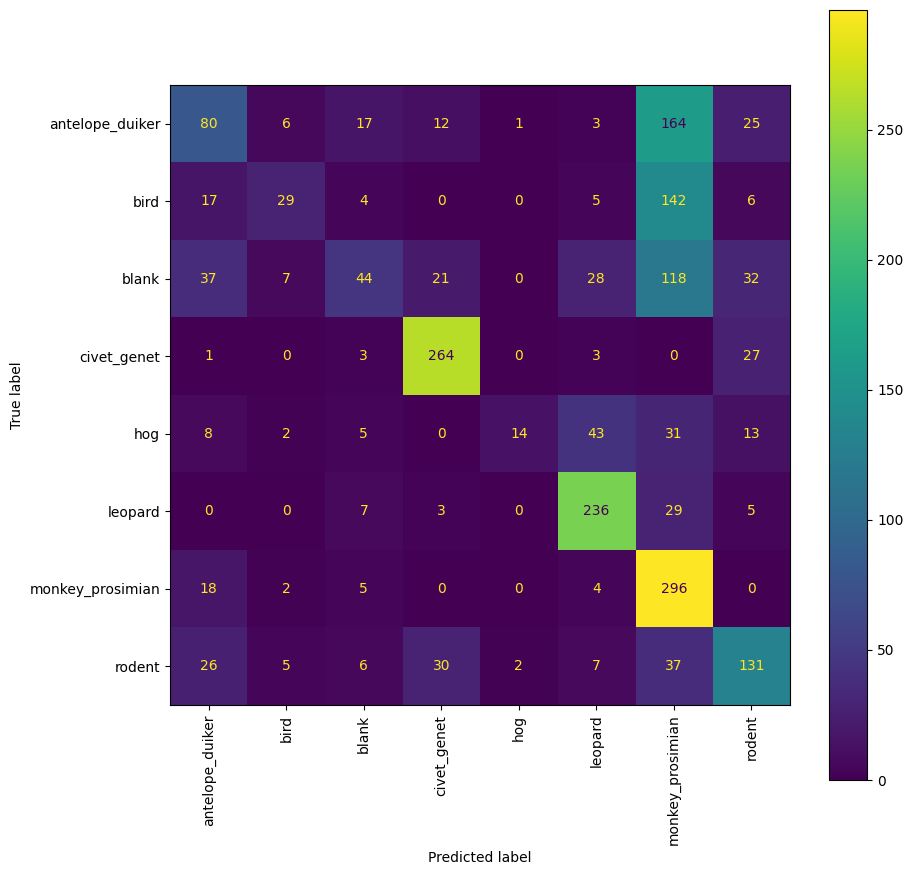

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

Looks like we're ready to submit! Save the dataframe out to a CSV file and then upload it via the [Submissions page](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/submissions/) on the competition website.

| Loss Function    | Accuracy |
|------------------|----------|
| CrossEntropyLoss |0.53954391072295|
| KLDivergence     | 0.529839883551674 |
| Focal Loss       | 0.4983017952450267    |
| LabelSmoothing   | 0.5104318292091218